# Automatic Object Detector

In [160]:
import numpy as np
import pandas as pd
import geopandas as gpd
import open3d as o3d
from shapely.geometry import Point, LineString, box, MultiPoint
from shapely.ops import cascaded_union
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
import folium

In [161]:
INPUT_FILE = 'wreck_2.xyz'
GRID_SIZE = 1
THRESHOLD = 0.2
BUFFER_DISTANCE = 1
OUTPUT_FILE = 'wreck_2.html'
OUTPUT_TABLEAU_1 = 'polygon_wreck_2.shp'
OUTPUT_TABLEAU_2 = 'points_wreck_2.geojson'
OUTPUT_TABLEAU_3 = 'stats_wreck_2.geojson'

## Define functions

In [162]:
# STEP 1:
def format_file(file_raw, file_formatted):
    with open(file_raw, 'r') as file:
        # Read the lines from the text file
        lines = file.readlines()
        # Create empty lists to store extracted columns
        column1 = []
        column2 = []
        column3 = []
       # Loop through each item in the 'line' list
        for line in lines:
            # Split the line by ' ' to separate columns
            columns = line.strip().split(' ')
            # Extract the Lat, Long and Depth columns and store them in separate variables
            column1.append(columns[0])
            column2.append(columns[1])
            column3.append(columns[2])

        # Create an xyz file to write the extracted columns
        with open(file_formatted, 'w') as output_file:
            # Loop through the extracted columns and write to the xyz file
            for i in range(len(column1)):
                output_file.write(f"{column2[i]} {column1[i]} {column3[i]}\n")
        print("Data has been saved to ", file_formatted, " file.")
        
# STEP 2:       
def load_print(file):
    pcd = o3d.io.read_point_cloud(file)
    print(pcd)
    pc = np.asarray(pcd.points)
    np.set_printoptions(suppress=True, precision=3)
    print(pc)
    return pc, pcd

# STEP 3:
def create_point_geodataframe(pc):
    df = pd.DataFrame(pc)
    df.columns = ['x', 'y','z']
    point_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['x'], df['y'], crs='epsg:32619'))
    point_gdf = point_gdf.drop(['x', 'y'], axis=1)
    print('Numpy point cloud loaded to a Pandas GeoDataFrame.')
    return point_gdf

def plot_point_geodataframe(point_gdf):
    point_gdf.plot(marker='o', column='z', cmap='terrain', markersize=20)
    plt.xticks(rotation=90)
    plt.title('Point Cloud')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.show()

# STEP 4:
def create_grid_geodataframe(point_gdf, grid_size):
    min_x, min_y, max_x, max_y = point_gdf.geometry.total_bounds
    grid_x = np.arange(min_x - 0.8, max_x + 0.8, grid_size)
    grid_y = np.arange(min_y - 0.8, max_y + 0.8, grid_size)
    grid_gdf = gpd.GeoDataFrame(geometry=[box(x, y, x + grid_size, y + grid_size) for x in grid_x for y in grid_y], crs='epsg:32619')
    grid_gdf['cell_id'] = grid_gdf.index
    print('Grid loaded to a Pandas GeoDataFrame.')
    return grid_gdf


# STEP 5
def point_grid_join(point_gdf, grid_gdf):
    point_gdf = gpd.sjoin(point_gdf, grid_gdf, how='left', predicate='within')
    point_gdf = point_gdf[['z', 'geometry', 'cell_id']]
    print('Point and Grid geodataframes joined together.')
    return point_gdf

def plot_point_grid(point_gdf, grid_gdf):
    fig, ax = plt.subplots(figsize=(20,20))
    grid_gdf.plot(ax=ax, column='cell_id', color='none', edgecolor='black', linewidth=1)
    # for index, row in grid_gdf.iterrows():
        # ax.annotate(text=row['cell_id'], xy=row['geometry'].centroid.coords[0], ha='center', va='center')
    point_gdf.plot(ax=ax, marker='o', column='z', cmap='terrain', markersize=20,  legend=True)
    plt.title('Point Cloud and Grid')
    plt.xlabel('X')
    plt.ylabel('Y')
    ax.ticklabel_format(useOffset=False, style='plain')
    plt.xticks(rotation=90)
    plt.show()

# STEP 6:
def create_stats_geodataframe(point_gdf, grid_gdf):
    stats_df = point_gdf.groupby('cell_id').agg({'z': ['mean', 'min', 'max','std', 'count']})
    stats_df.columns = ['_'.join(col).strip() for col in stats_df.columns.values]
    stats_df = stats_df.reset_index()
    stats_gdf = gpd.GeoDataFrame(stats_df)
    stats_gdf = pd.merge(grid_gdf, stats_gdf, on='cell_id', how='left')
    return stats_gdf

def plot_stats_geodataframe(merged_gdf):
    fig, ax = plt.subplots(figsize=(20, 20))
    for idx, centroid in enumerate(merged_gdf.centroid):
        ax.text(centroid.x, centroid.y, f'{idx}', ha='center', va='center', fontsize=5)
    merged_gdf.plot(ax=ax,color='none', edgecolor='black', linewidth=1)
    merged_gdf.plot(ax=ax, column='z_std', legend=True)
    plt.title('Standard Deviation per cell')
    plt.xlabel('X')
    plt.ylabel('Y')
    ax.ticklabel_format(useOffset=False, style='plain')
    plt.xticks(rotation=90)
    plt.show()

# STEP 7: 
def object_detector(stats_gdf, point_gdf, threshold, buffer_distance):
    selected_grid = stats_gdf[stats_gdf.z_std > threshold]
    cells = selected_grid['cell_id'].to_list()
    selected_points = point_gdf[point_gdf.cell_id.isin(cells)]

    # Create a polygon for each group of points above the threshold
    grouped_points = selected_points.groupby('cell_id')
    polygons = [grouped_points.get_group(cell).unary_union.convex_hull for cell in grouped_points.groups]

    # Combine all polygons into a single MultiPolygon
    multi_polygon = cascaded_union(polygons)

    # Create a buffer around the MultiPolygon to ensure that every point in the geodataframe is included
    buffered_polygon = multi_polygon.buffer(buffer_distance)

    # Create a GeoDataFrame for the bounding polygon
    bounding_polygon = gpd.GeoDataFrame({'geometry': [buffered_polygon]}, crs='epsg:32619')

    # Find the centroid of the bounding polygon
    centroid = buffered_polygon.centroid

    # Find the points within the bounding polygon
    points_within_polygon = gpd.sjoin(point_gdf, bounding_polygon, predicate='within')
    points_within_polygon = gpd.GeoDataFrame(points_within_polygon, geometry='geometry')
    return bounding_polygon, points_within_polygon

def plot_object(bounding_polygon, points_within_polygon, merged_gdf):
    fig, ax = plt.subplots(figsize=(20, 20))
    # for idx, centroid in enumerate(merged_gdf.centroid):
    #     ax.text(centroid.x, centroid.y, f'{idx}', ha='center', va='center', fontsize=5)
    merged_gdf.plot(ax=ax,color='none', edgecolor='black', linewidth=1)
    # filtered_grid.plot(ax=ax, column='z_std', legend=True)
    points_within_polygon.plot(ax=ax, marker='o', column='z', cmap='terrain', markersize=20,  legend=True)
    bounding_polygon.plot(ax=ax,color='none', edgecolor='red', linewidth=2)
    bounding_polygon.centroid.plot(ax=ax, marker='x', color='red', markersize=100)
    plt.title('Extracted points')
    plt.xlabel('X')
    plt.ylabel('Y')
    ax.ticklabel_format(useOffset=False, style='plain')
    plt.xticks(rotation=90)
    plt.show()

def interactive_map(bounding_polygon, points_within_polygon, output_file):
    m = folium.Map(location=[2.5888, -34.5171], zoom_start=19, max_zoom=100)
    bounding_polygon.explore(
        m=m,
        style_kwds=dict(color="red",fillOpacity=0),
        name="polygon"
    )
    points_within_polygon.explore(
        m=m,
        column="z",
        cmap="rainbow", 
        popup=True,
        tooltip="z",
        name="points",
        legend=True,
    )
    folium.LayerControl().add_to(m)
    m.add_child(folium.LatLngPopup())
    m.save(output_file)
    return m

def tableau_export(bounding_polygon, points_within_polygon, stats_gdf, output_tableau_1, output_tableau_2, output_tableau_3):
    bounding_polygon.to_file(output_tableau_1)
    points_within_polygon.to_file(output_tableau_2, driver='GeoJSON')
    stats_gdf.to_file(output_tableau_3, driver='GeoJSON')
    

## Run Code

In [163]:
# STEP 2: LOAD .XYZ AS NUMPY ARRAY. PRINT AND RENDER POINT CLOUD

pc, pcd = load_print(INPUT_FILE)

PointCloud with 2312 points.
[[4588833.     347557.5       -13.574]
 [4588833.     347558.        -13.59 ]
 [4588833.     347558.5       -13.594]
 ...
 [4588853.     347584.        -12.831]
 [4588853.     347584.5       -12.832]
 [4588853.     347585.        -12.921]]


In [164]:
# STEP 2 (visualization): PLOT POINT CLOUD USING OPEN3D

o3d.visualization.draw_geometries([pcd])

In [165]:
point_gdf = create_point_geodataframe(pc)
point_gdf.head()

Numpy point cloud loaded to a Pandas GeoDataFrame.


,z,geometry
0,-13.574,POINT (4588833.000 347557.500)
1,-13.590,POINT (4588833.000 347558.000)
2,-13.594,POINT (4588833.000 347558.500)
3,-13.593,POINT (4588833.000 347559.000)
4,-13.587,POINT (4588833.000 347559.500)


In [166]:
grid_gdf = create_grid_geodataframe(point_gdf, GRID_SIZE)
grid_gdf.head()

Grid loaded to a Pandas GeoDataFrame.


,geometry,cell_id
0,"POLYGON ((4588833.200 347554.700, 4588833.200 ...",0
1,"POLYGON ((4588833.200 347555.700, 4588833.200 ...",1
2,"POLYGON ((4588833.200 347556.700, 4588833.200 ...",2
3,"POLYGON ((4588833.200 347557.700, 4588833.200 ...",3
4,"POLYGON ((4588833.200 347558.700, 4588833.200 ...",4


In [167]:
point_gdf = point_grid_join(point_gdf, grid_gdf)
point_gdf.head()

Point and Grid geodataframes joined together.


,z,geometry,cell_id
0,-13.574,POINT (4588833.000 347557.500),2
1,-13.590,POINT (4588833.000 347558.000),3
2,-13.594,POINT (4588833.000 347558.500),3
3,-13.593,POINT (4588833.000 347559.000),4
4,-13.587,POINT (4588833.000 347559.500),4


C:\Users\garpa\anaconda3\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


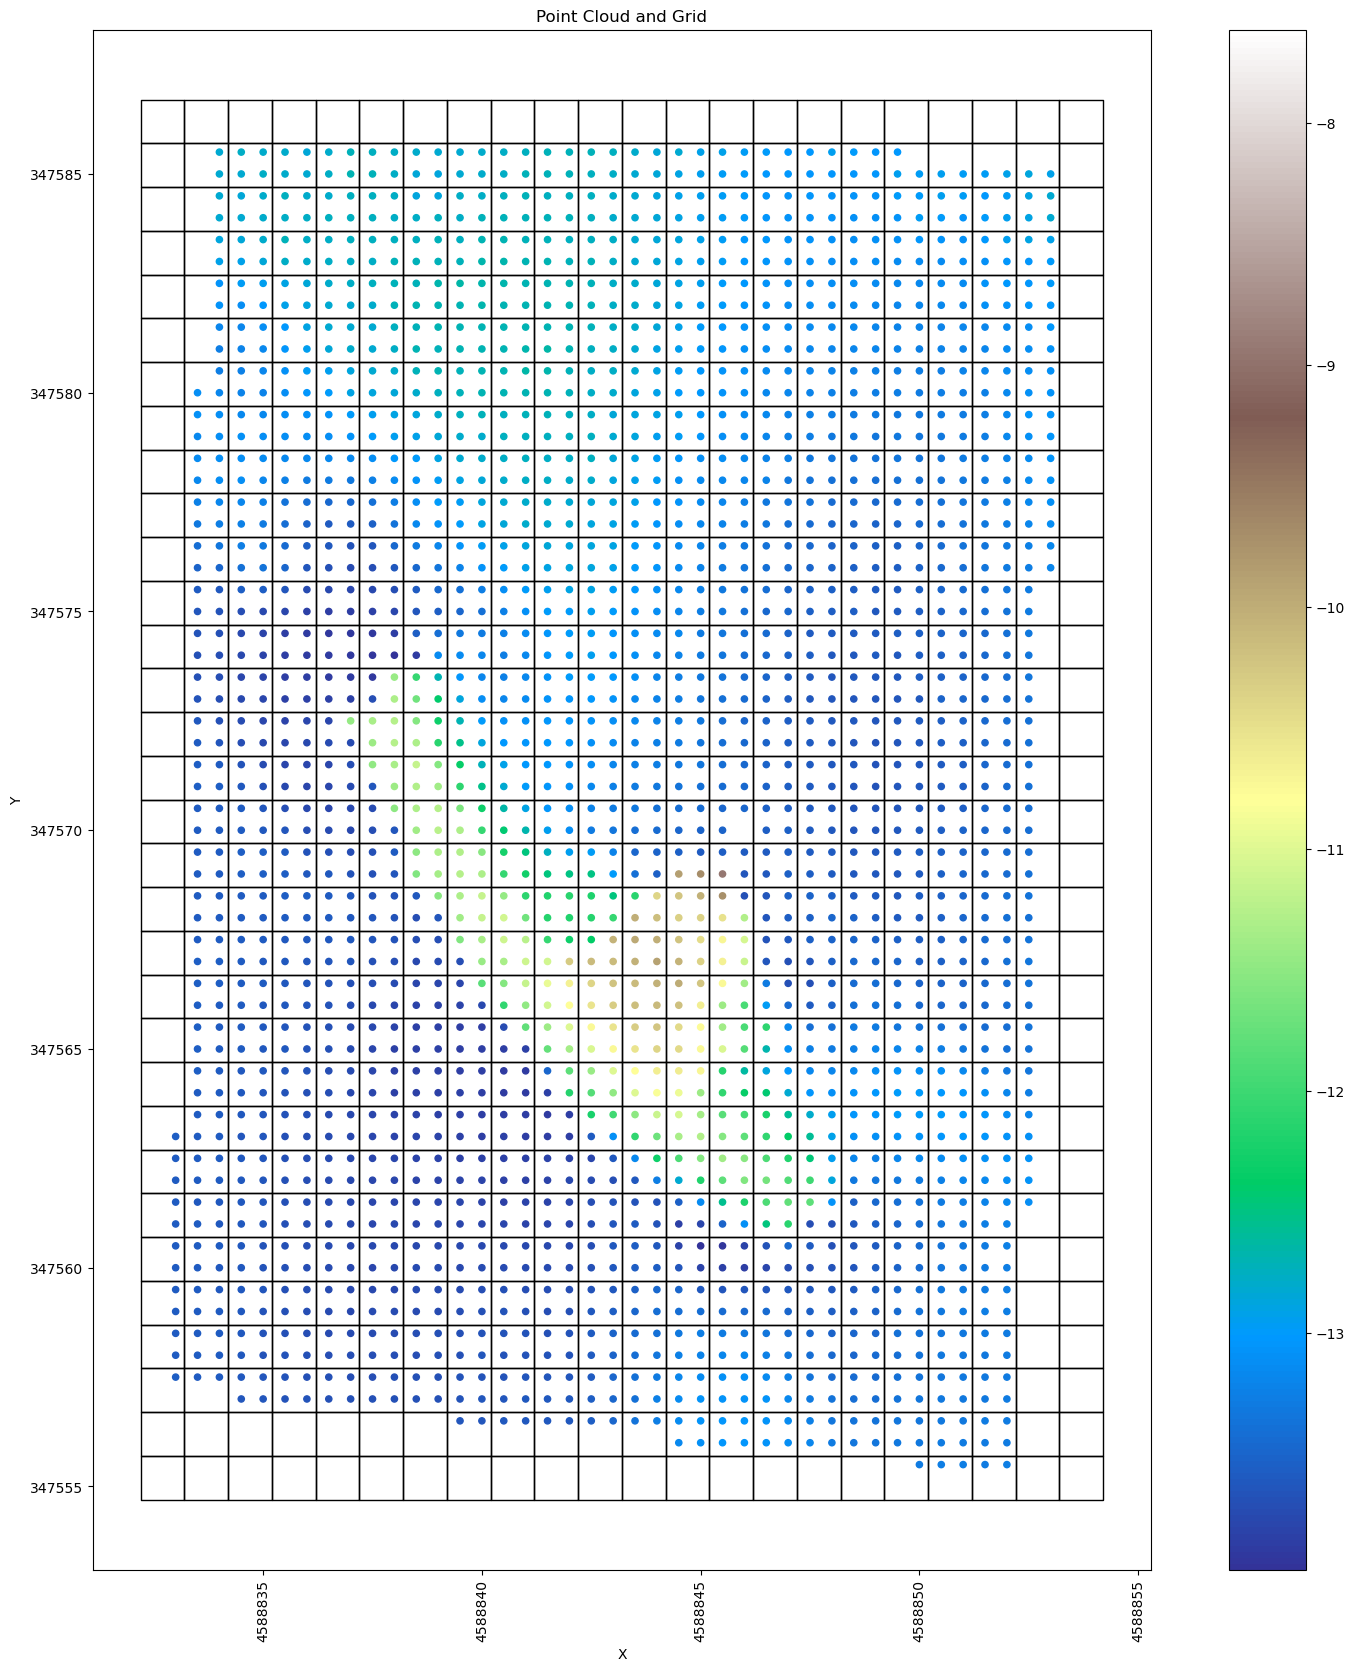

In [168]:
plot_point_grid(point_gdf, grid_gdf)


In [169]:
stats_gdf = create_stats_geodataframe(point_gdf, grid_gdf)
print(stats_gdf.crs)
stats_gdf.head()

epsg:32619


,geometry,cell_id,z_mean,z_min,z_max,z_std,z_count
0,"POLYGON ((4588833.200 347554.700, 4588833.200 ...",0,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((4588833.200 347555.700, 4588833.200 ...",1,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((4588833.200 347556.700, 4588833.200 ...",2,-13.574,-13.574,-13.574,NaN,1.0
3,"POLYGON ((4588833.200 347557.700, 4588833.200 ...",3,-13.592,-13.594,-13.590,0.002828,2.0
4,"POLYGON ((4588833.200 347558.700, 4588833.200 ...",4,-13.590,-13.593,-13.587,0.004243,2.0


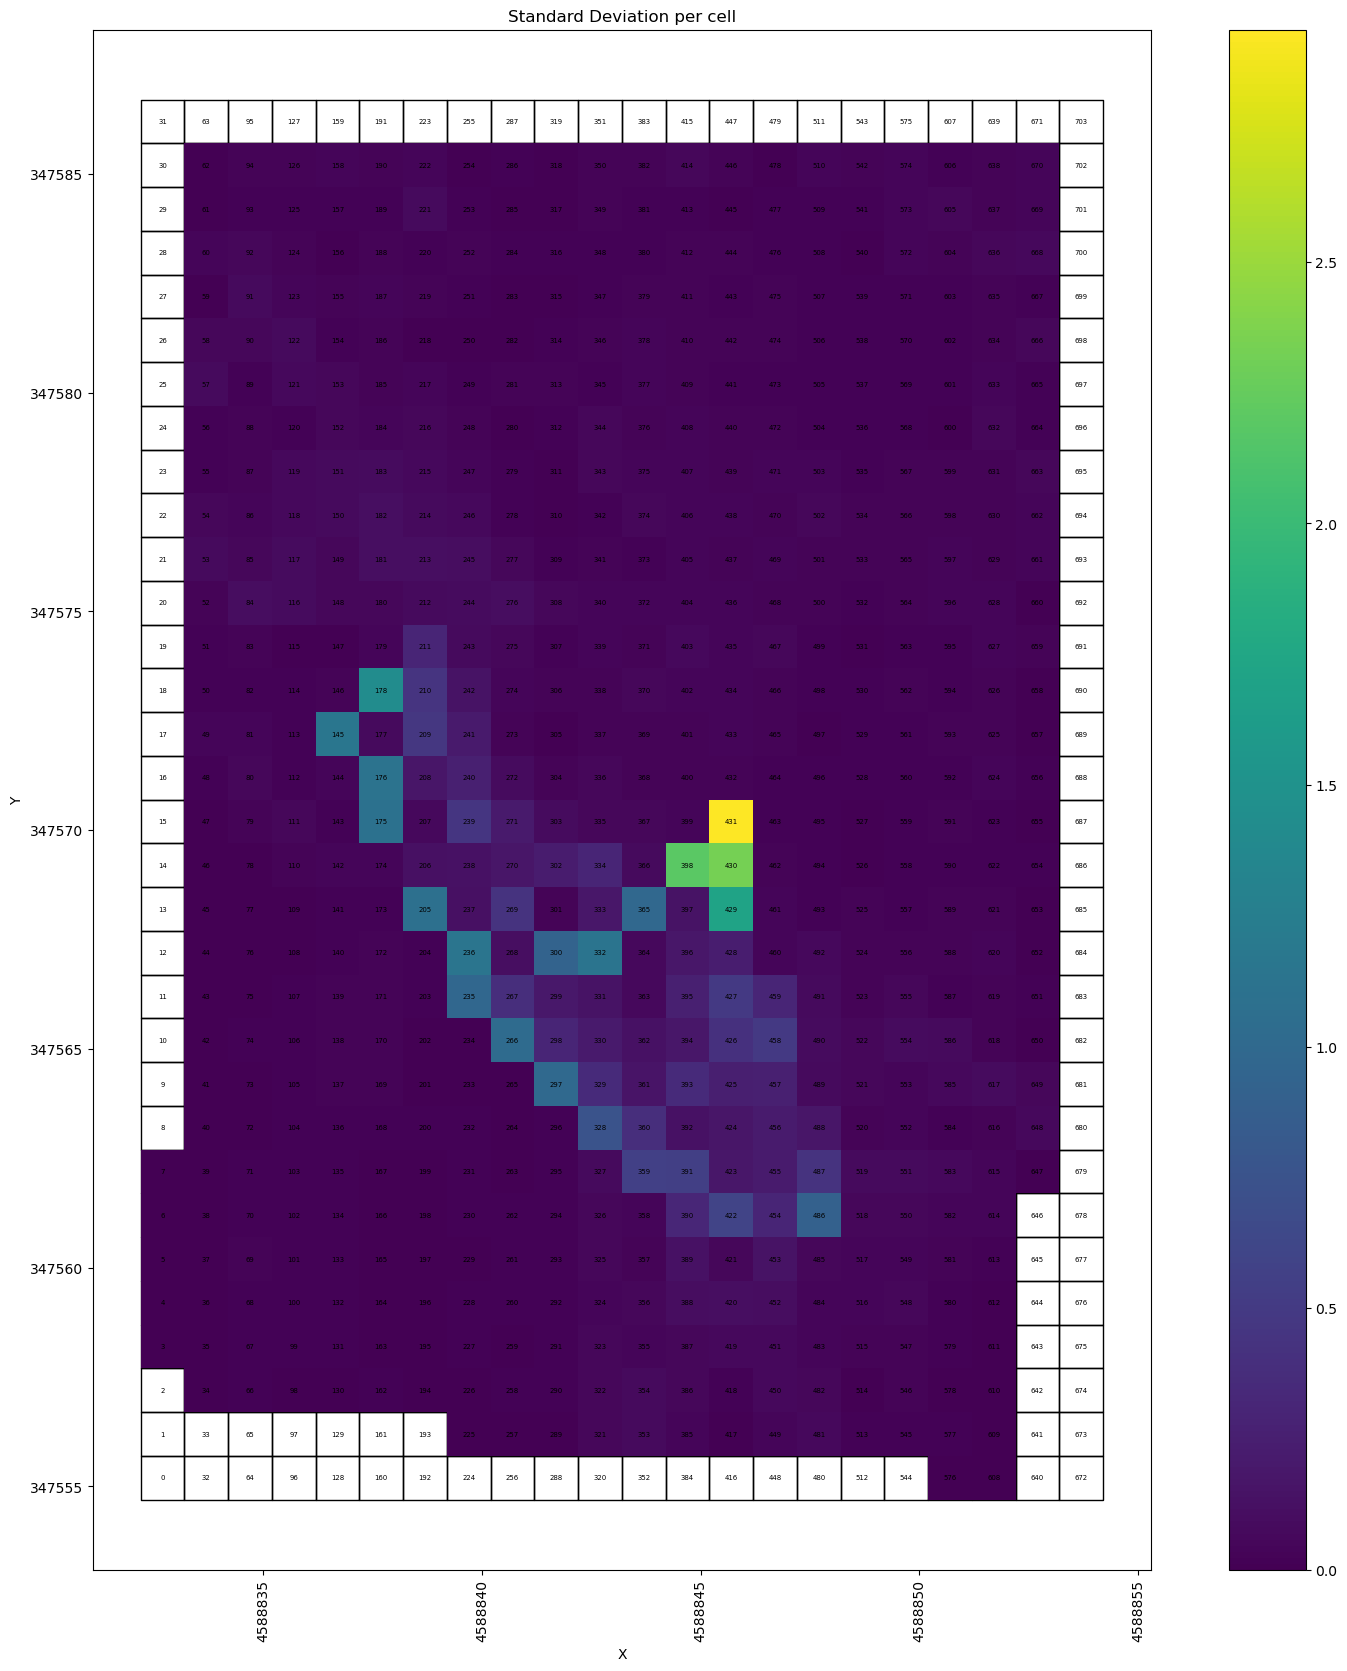

In [170]:
plot_stats_geodataframe(stats_gdf)


In [172]:
bounding_polygon, points_within_polygon = object_detector(stats_gdf, point_gdf, THRESHOLD, BUFFER_DISTANCE)


C:\Users\garpa\AppData\Local\Temp\ipykernel_10740\183314696.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  multi_polygon = cascaded_union(polygons)


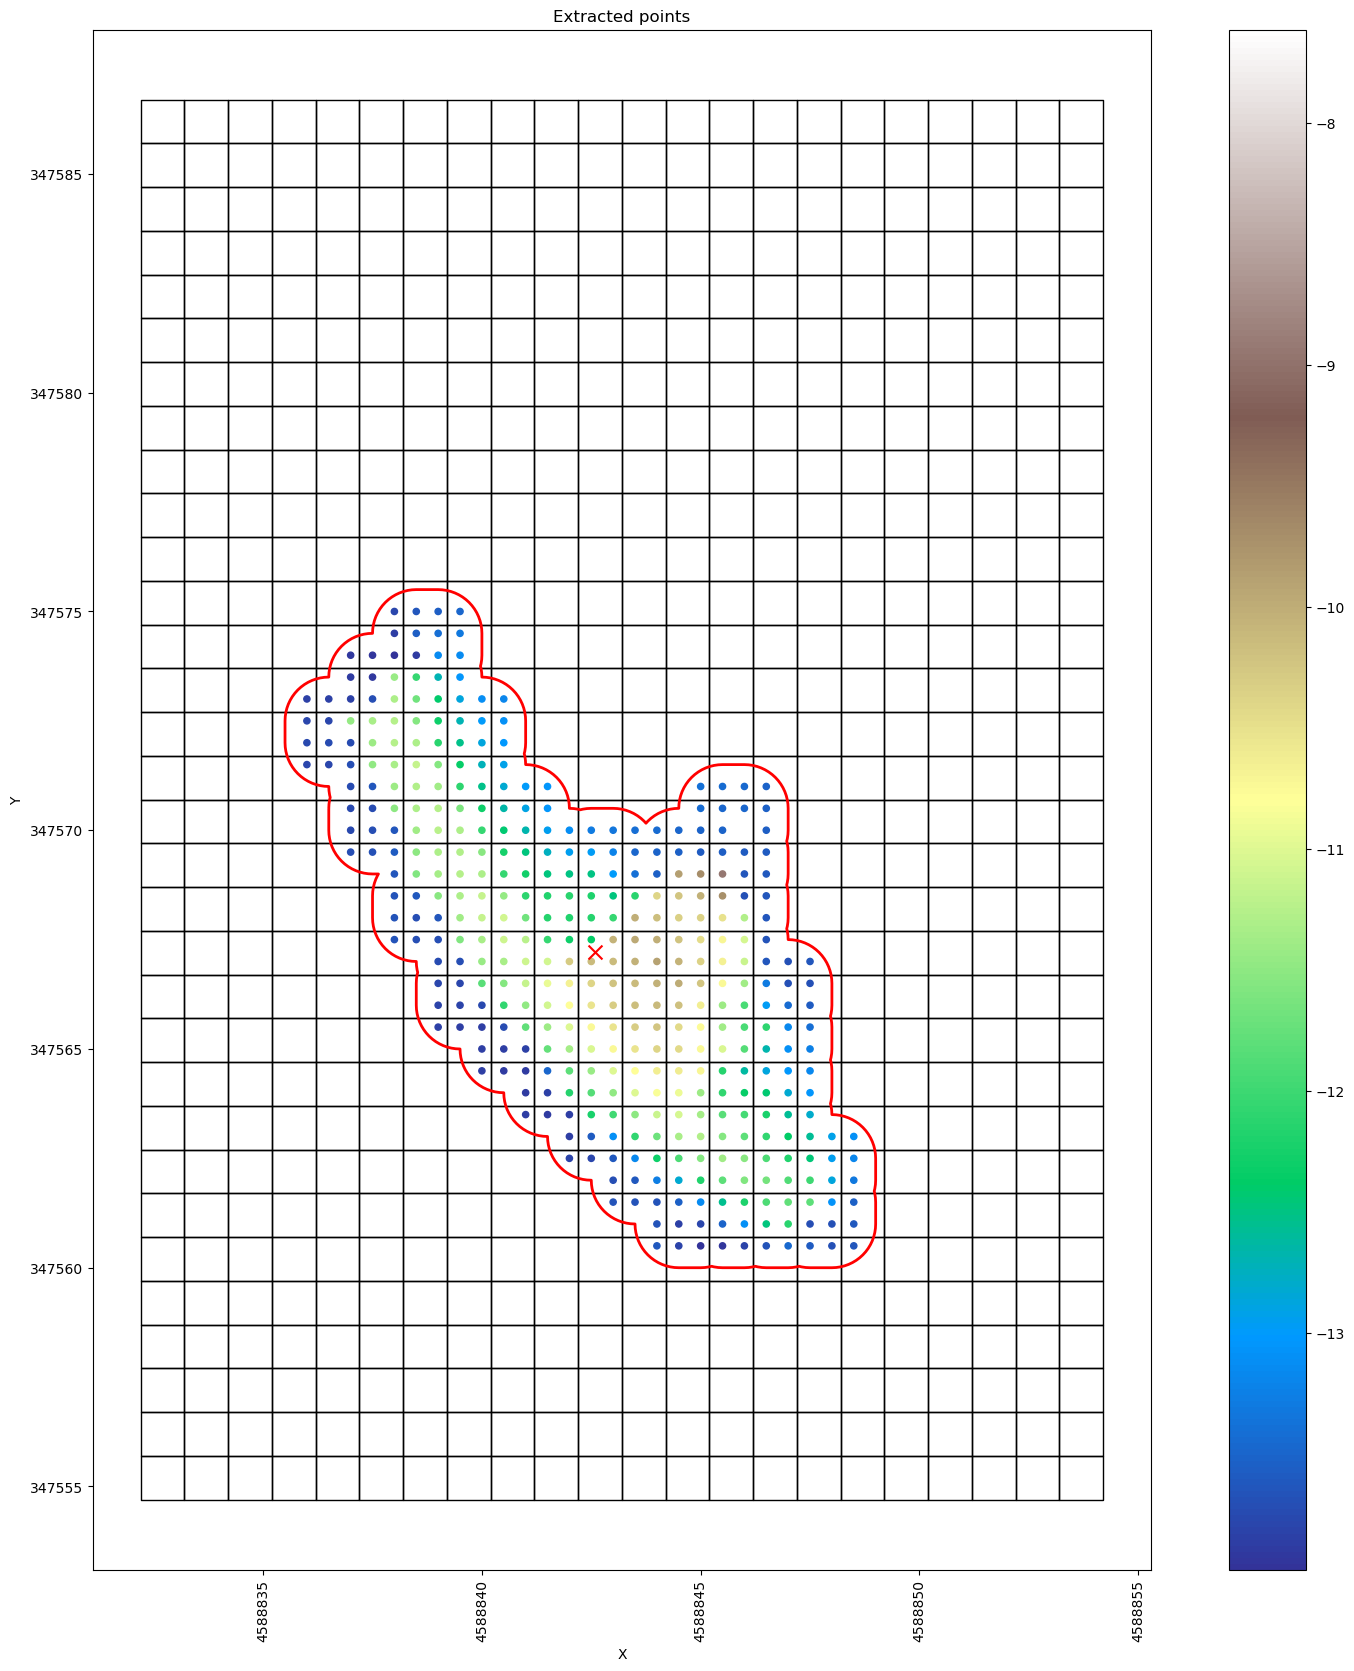

In [173]:
plot_object(bounding_polygon, points_within_polygon, stats_gdf)

In [174]:
m = interactive_map(bounding_polygon, points_within_polygon, OUTPUT_FILE)
m

In [159]:
tableau_export(bounding_polygon, points_within_polygon, stats_gdf, OUTPUT_TABLEAU_1, OUTPUT_TABLEAU_2, OUTPUT_TABLEAU_3)